# ABS Inflation multi-measure

## Python set-up

In [1]:
# system imports
from pathlib import Path

# analytic imports
import matplotlib.pyplot as plt
import pandas as pd

# local imports
from abs_data_capture import (find_id, get_abs_meta_and_data, get_fs_constants,
                              get_meta_constants)
from plotting import clear_chart_dir, line_plot, set_chart_dir, finalise_plot

# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# display charts in this notebook
SHOW = True

## Get data from ABS

In [2]:
# ABS data extraction settings
did_col, id_col, table_col, type_col, unit_col, tdesc_col = get_meta_constants()

In [3]:
def get_series(
    catalogue_id: str, table: str, series_type: str, did_type: str, series_name: str
) -> pd.Series:
    """Return the series that matches the selection criteria in the parameters."""

    # get the ABS data
    data_dict = get_abs_meta_and_data(catalogue_id)
    _, _, meta_data = get_fs_constants(catalogue_id)
    meta = data_dict[meta_data]
    data = data_dict[table]

    # get the identified series
    search_terms = {
        table: table_col,
        "Seasonally Adjusted" if series_type == "SA" else "Original": type_col,
        did_type: did_col,
        series_name: did_col,
    }
    series_id, _ = find_id(meta, search_terms, verbose=True)
    series = data[series_id]

    return series

In [4]:
def calculate_growth(series, name, did_type):
    """Work out if we need to calculate annual growth,
    and if we do, then calculate growth.
    Return a series of percentage growth."""

    # preliminary
    period = series.index.freqstr[0]
    shift = 4 if period == "Q" else 12 if period == "M" else 0
    if not shift:
        print(f"--- Something odd---: {name} {series.index.freqstr}")

    # treat series appropriately
    # -- already annual growth, so no treatment needed
    dt_lower = did_type.lower()
    if "percent" in dt_lower and "previous year" in dt_lower:
        growth = series

    # -- calculate annual growth from raw series
    else:
        growth = series.pct_change(periods=shift) * 100

    # upsample quarterly data to monthly before returning it
    if period == "Q":
        growth = growth.resample("M", convention="end").mean()

    return growth

In [5]:
def get_all_data() -> tuple[pd.DataFrame, str, str]:
    """Get all relevant data series in a DataFrame.
    Return a tuple:
    * that DataFrame,
    * a source string to footnote charts, and
    * a latest vales string."""

    capture = {
        # specify the data items we wish to capture ...
        # raw data - we will calculate growth from index numbers/etc.
        # description: [catalogue_id, table, series_type, did_type, series_name, summary]
        "All Groups CPI": [
            "6401",
            "2",
            "Orig",
            "Percentage Change from Corresponding Quarter of Previous Year",
            "All groups CPI ;  Australia ;",
            "CPI",
        ],
        "CPI Trimmed Mean": [
            "6401",
            "8",
            "SA",
            "Percentage Change from Corresponding Quarter of Previous Year",
            "Trimmed Mean ;  Australia ;",
            "CPI-TM",
        ],
        "Monthly CPI Indicator": [
            "6484",
            "1",
            "SA",
            "Percentage Change from Corresponding Month of Previous Year",
            "All groups CPI, seasonally adjusted ;  Australia",
            "M-CPI",
        ],
        "Monthly ex. vol. items and holiday trav.": [
            "6484",
            "1",
            "SA",
            "Percentage Change from Corresponding Month of Previous Year",
            "excluding 'volatile items' and holiday travel ;  Australia ;",
            "M-exVI&HT",
        ],
        "Producer Price Index": [
            "6427",
            "1",
            "Orig",
            "Percentage change from corresponding quarter of previous year",
            "Final ;  Total ",
            "PPI",
        ],
        "Wage Price Index": [
            "6345",
            "1",
            "SA",
            "Percentage Change From Corresponding Quarter of Previous Year",
            "Australia ;  Total hourly rates of pay excluding bonuses ;  "
            + "Private and Public ;  All industries ;",
            "WPI",
        ],
        "GDP Price Deflator": [
            "5206",
            "5",
            "SA",
            " ",
            "GROSS DOMESTIC PRODUCT ;",
            "GDP",
        ],
        "Households final consumption Price Deflator": [
            "5206",
            "5",
            "SA",
            " ",
            "Households ;  Final consumption expenditure ;",
            "HFCE",
        ],
        "Non-farm hourly employee compensation": [
            "5206",
            "24",
            "SA",
            "Current prices ;",
            "Non-farm compensation of employees per hour:",
            "NFHEC",
        ],
    }

    # let's download the ABS data
    combined = {}
    latest_ = []
    sources = set()
    for name, (
        catalogue_id,
        table,
        series_type,
        did_type,
        series_name,
        summary,
    ) in capture.items():
        sources.add(catalogue_id)
        series = get_series(catalogue_id, table, series_type, did_type, series_name)
        growth = calculate_growth(series, name, did_type)
        full_name = f"{name} ({series_type})"
        growth.name = full_name
        combined[full_name] = growth
        latest_.append(f"{summary}={round(growth.dropna().iloc[-1], 1)}")

    return (
        pd.DataFrame(combined),
        f"ABS {', '.join(sorted(sources))}",
        f"Latest reported: {', '.join(latest_)}.",
    )


frame, source, latest = get_all_data()
print("\n", latest)

Found URL for a ZIP file on ABS web page
Retrieving data from the cache file: ABS_CACHE/5f6bd6bc84c24ad0c445fc096bd08fbd--All-Time-Series-Spreadsheets.zip
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving data from the cache file: ABS_CACHE/7a5a63f14a14e9dd35e20efad2c5af41--All-Time-Series-Spreadsheets.zip
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving data from the cache file: ABS_CACHE/2730dbc50662e3c1b4951c4e7087e933--Time-series-all.zip
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving data from the cache file: ABS_CACHE/6052268df887aaf3a0774941b419dc9b--Time-series-spreadsheets-all.zip
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving data from the cache file: ABS_CACHE/5017be8287dea982b865689c39593eff--All_time_series_workbooks.zip
Extracting DataFrames from the zip-file ...

 Latest reported: CP

## Plot the data

In [6]:
def plot_settings():
    """Plot settings."""

    chart_dir = "./CHARTS/Inflation"
    Path(chart_dir).mkdir(parents=True, exist_ok=True)
    clear_chart_dir(chart_dir)
    set_chart_dir(chart_dir)
    plt.style.use("fivethirtyeight")


plot_settings()

In [7]:
TARGET = {
    "ymin": 2,
    "ymax": 3,
    "color": "#dddddd",
    "label": "2-3% inflation target",
    "zorder": -1,
}


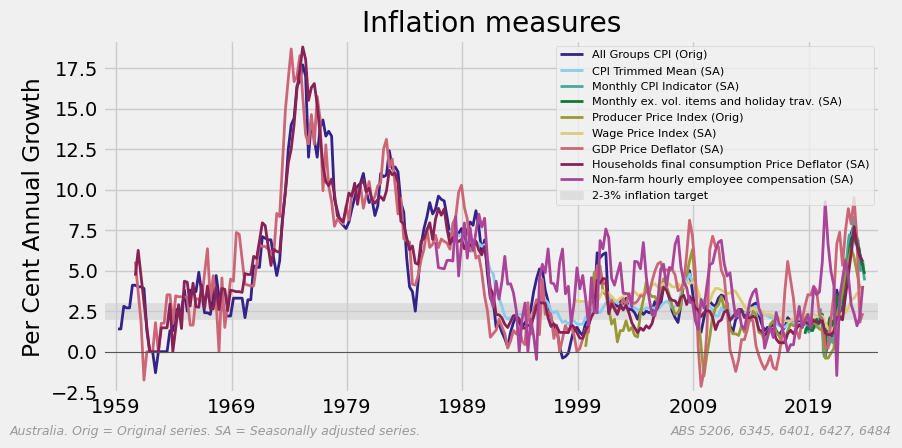

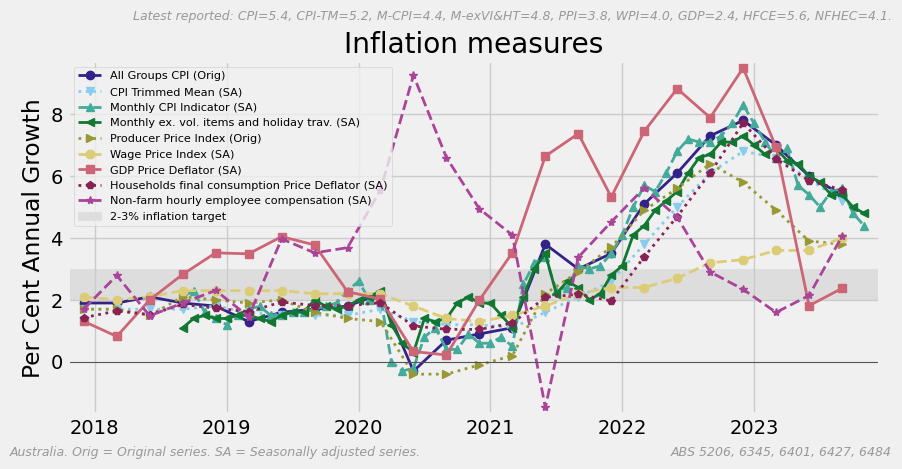

In [8]:
def plot_multi_inflation():
    """Produce the mulit-mesure inflation charts."""

    starts = ("1959-01-01", "2017-11-01")
    styles = (None, ["solid", "dotted", "dashed"] * 3)
    markers = (
        None,
        ["o", "v", "^", "<", ">", "8", "s", "p", "*", "h", "H", "D", "d", "P", "X"],
    )

    for start, style, marker in zip(starts, styles, markers):
        line_plot(
            frame,
            starts=start,
            style=style,
            marker=marker,
            markersize=6,
            dropna=True,
            title="Inflation measures",
            ylabel="Per Cent Annual Growth",
            legend={"fontsize": "xx-small"},
            axhspan=TARGET,
            y0=True,
            rfooter=source,
            lfooter="Australia. Orig = Original series. "
            "SA = Seasonally adjusted series. ",
            rheader=latest if start != starts[0] else None,
            tags=start if start is not None else "",
            show=SHOW,
        )


plot_multi_inflation()

### Weighted CPI trajectory

2023-12    4.5
2024-03    3.8
2024-06    3.1
2024-09    2.4
Freq: M, dtype: float64


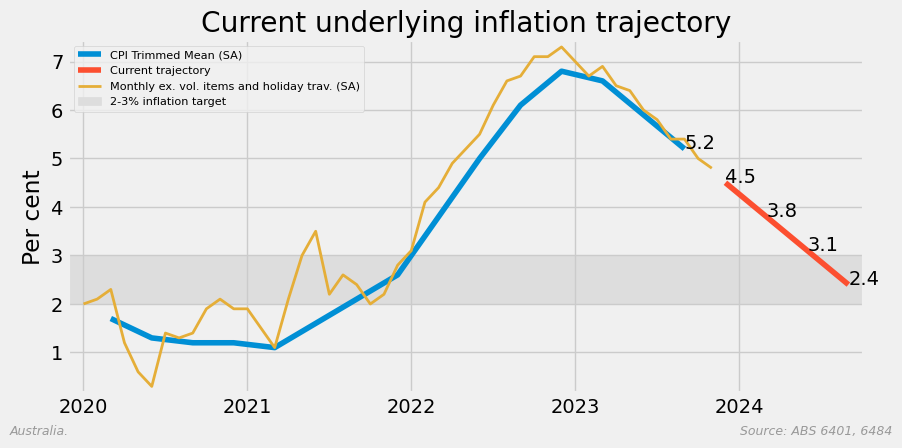

1.1666666666666665 -0.6999999999999997


In [20]:
def trajectory(frame: pd.Series):

    THRESH = 2.5
    SERIES = "CPI Trimmed Mean (SA)"
    MONTHLY  = "Monthly ex. vol. items and holiday trav. (SA)"
    cpiwm_mon = frame[SERIES][frame.index.year >= 2020].dropna()
    cpiwm_q = cpiwm_mon.resample('Q').mean()
    cpi_mon = frame[MONTHLY][frame.index.year >= 2020]
    start = cpiwm_q[cpiwm_q > 2.5].index[0]
    peak = cpiwm_q[cpiwm_q == cpiwm_q.max()].index[0]
    tail = cpiwm_q.index[-1]

    up_rate = (cpiwm_q[peak-1] - cpiwm_q[start]) / ((peak-1) - start).n
    down_rate = (cpiwm_q[tail] - cpiwm_q[peak+1]) / (tail - (peak+1)).n

    s = pd.Series()
    count = 0
    while True:
        count = count + 1
        pos = tail + count
        s[pos] = cpiwm_q[tail] + (down_rate * count)
        if s[pos] <= THRESH:
            break
    s = s.resample('M', convention='end').sum().dropna()
    print(s)

    ax = cpiwm_mon.plot(label=SERIES)
    s.plot(ax=ax, label='Current trajectory')
    cpi_mon.plot(ax=ax, lw=2, label=MONTHLY)
    
    for x in s.index:
        ax.text(x, s[x], round(s[x], 1))
    ax.text(cpiwm_mon.index[-1], cpiwm_mon.iloc[-1], round(cpiwm_mon.iloc[-1], 1))

    finalise_plot(
        axes=ax,
        title=f"Current underlying inflation trajectory",
        ylabel="Per cent",
        legend={"fontsize": "xx-small", "loc": "upper left", },
        axhspan=TARGET,
        lfooter='Australia. ',
        rfooter='Source: ABS 6401, 6484',
        show=True,
    )

    print(up_rate, down_rate)


trajectory(frame)

## Finished

In [ ]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

In [ ]:
print("Finished")